## Downloading Dependencies

In [1]:
# install torchaudio
!pip install torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 8.8MB/s 
     |████████████████████████████████| 577.3MB 25kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.7.0+cu92 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.0+cu92 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102


In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
# current torch version is 1.7.0+cu101
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd



In [4]:
#For augmentation
import random
import itertools
import librosa
import soundfile as sf
#import wave

In [5]:
# check if cuda GPU is available, make sure you're using GPU runtime on Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # you should output "cuda"

cuda


## Speech Classification Dataset
We will be providing the base dataset that will be used for the first task of the Speech Classification competition.

In [6]:
# #mount my drive
# from google.colab import drive
# drive.mount('/gdrive')

In [59]:
####
#ORIGINAL
#####
# !gdown --id 1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
# !unzip s1_train_release.zip

####
#MY OWN DATASET
###

#if mmount i dont need to redownload
#COMBINED_DATASET NOT AUGMENTED
# !gdown https://drive.google.com/u/1/uc?id=1uHctV_bDqJUsx9WgE71XOisS1OFzfLBA&export=download
# !unzip combined_dataset.zip

#COMBINED_DATASET BASE AUGMENETED for s1
# !gdown https://drive.google.com/u/1/uc?id=1xgEMpHk1sGzSQRSQPdbMvgcezX_jms4u&export=download
# !unzip combined_dataset_KaggleNotAugmented.zip

#s1_s2_kaggle_train_release.zip
!gdown https://drive.google.com/u/1/uc?id=1H1QCMGA8pLdmVSF7IWPj30uXaNoczPyk&export=download
!unzip s1_s2_kaggle_train_release.zip

#s1_s2_speechcommand_egg_train_release.zip
# !gdown https://drive.google.com/u/1/uc?id=1lSklFIIGVQ5Xbhqg-2o2TwhTHHhYXeDd&export=download
# !unzip s1_s2_speechcommand_egg_train_release.zip

#challenge 4 easter egg extra dataset
# !gdown https://drive.google.com/u/1/uc?id=15ziGH3yQvFJPYuS4fv7IDge5E2ga2XDr&export=download
# !unzip challenge_4_egg.zip

Streaming output truncated to the last 5000 lines.
  inflating: s1_s2_kaggle_train_release/three/1957.wav  
  inflating: s1_s2_kaggle_train_release/three/1958.wav  
  inflating: s1_s2_kaggle_train_release/three/1959.wav  
  inflating: s1_s2_kaggle_train_release/three/1962.wav  
  inflating: s1_s2_kaggle_train_release/three/1963.wav  
  inflating: s1_s2_kaggle_train_release/three/1964.wav  
  inflating: s1_s2_kaggle_train_release/three/1967.wav  
  inflating: s1_s2_kaggle_train_release/three/1968.wav  
  inflating: s1_s2_kaggle_train_release/three/1969.wav  
  inflating: s1_s2_kaggle_train_release/three/197.wav  
  inflating: s1_s2_kaggle_train_release/three/1972.wav  
  inflating: s1_s2_kaggle_train_release/three/1973.wav  
  inflating: s1_s2_kaggle_train_release/three/1974.wav  
  inflating: s1_s2_kaggle_train_release/three/1977.wav  
  inflating: s1_s2_kaggle_train_release/three/1978.wav  
  inflating: s1_s2_kaggle_train_release/three/1979.wav  
  inflating: s1_s2_kaggle_train_releas

In [ ]:
#Rename the combined_dataset to s1_train_release cause im lazy


In [70]:
#!ls

In [69]:
#copy and paste challenge 4 eggs content into the other folder
#!rsync -a challenge_4_egg/ s1_s2_kaggle_train_release/

In [71]:
#####################################
#AUGMENTING BY ADDING SYNTHETIC DATA
####################################
def load_audio_file(file_path):
    input_length = 16000
    data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000 sr=None perserves the sample rate, BUT I WANT ALL TO BE 16000
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data

def save_wav_file(path, data):
  sf.write(path, data, 16000)
  
# Adding white noise 
def white_noise(data):
    wn = np.random.randn(len(data))
    data_wn = data + 0.015*wn
    
    return data_wn

#Shifting the sound randomly
def shift(data, shift_direction = 'both'):
    shift = np.random.randint(16000 * 0.45) #sampling rate * shift_max
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

#Changing pitch
def pitch(data, pitch_factor):
    return librosa.effects.pitch_shift(data, 16000, pitch_factor)

#Changing speed
def speed(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

In [72]:
train_folder = 's1_s2_scnoisy_egg_train_release'

In [73]:
#tHE ACTUAL MAKING AND ADDING THE AUGMENTED FILES INTO THE RESPECTIVE FOLDERS
#ALSO RESAMPLIUNG EVERY WAV TO 16000

for label in os.listdir(f'/content/{train_folder}/'):
  for filename in os.listdir(f'/content/{train_folder}/{label}'):
    try:
      #to avoid augmenting the already augmented files 

      if 'AUGMENTED' in filename:
        continue

      #to augment oly the original given files, not the added kaggle dataset
      elif 'train' in filename:
        data = load_audio_file(f'/content/{train_folder}/{label}/{filename}')
        aug_name = filename[:-4] + '_AUGMENTED'
        
        #0 is false, 1 is true
        to_wn = random.choice([0,1])
        to_shift = random.choice([0,1])
        to_pitch = random.choice([0,1])
        to_speed = random.choice([0,1])

        
        #If no augmentation is to be done,REPEAT UNTIL THERE IS
        while (to_wn, to_shift, to_pitch, to_speed) == (0,0,0,0):
          to_wn = random.choice([0,1])
          to_shift = random.choice([0,1])
          to_pitch = random.choice([0,1])
          to_speed = random.choice([0,1])
  
        if to_pitch == 1:
          aug_name += '_pitch'
          pitch_factor = random.choice([-3,3])
          data = pitch(data, pitch_factor)
        
        if to_shift == 1:
          aug_name += '_shift'
          data = shift(data)

        if to_wn == 1:
          aug_name += '_wn'
          data = white_noise(data)

          
          #speed seems to gie problem because of the different sizes
          # if to_speed == 1:
          #   aug_name += '_speed'
          #   data = speed(data, random.choice([0.5, 1.5]))

          #save the new file into the same folder
        aug_name += '.wav'
        save_wav_file(f'/content/{train_folder}/{label}/{aug_name}', data)
        print('Saved: ', aug_name)

      #THIS IS TO RESAMPLE TO 16000
      else:
        data = load_audio_file(f'/content/{train_folder}/{label}/{filename}') #resamples to 16000
        save_wav_file(f'/content/{train_folder}/{label}/{filename}', data)
        print('Resampled: ', filename)


    except Exception as e:
      print(e)
      

    




    

Streaming output truncated to the last 5000 lines.
Resampled:  1769.wav
Resampled:  1413.wav
Resampled:  573.wav
Resampled:  2329.wav
Resampled:  1469.wav
Saved:  train_zero_4408_AUGMENTED_shift.wav
Resampled:  554.wav
Resampled:  1263.wav
Resampled:  1873.wav
Resampled:  1789.wav
Resampled:  373.wav
Resampled:  882.wav
Resampled:  1903.wav
Resampled:  282.wav
Resampled:  894.wav
Resampled:  742.wav
Resampled:  2362.wav
Resampled:  2437.wav
Resampled:  2448.wav
Saved:  train_six_4171_AUGMENTED.wav
Saved:  train_six_3998_AUGMENTED_shift_wn.wav
Resampled:  68.wav
Resampled:  614.wav
Saved:  train_six_4137_AUGMENTED_pitch_shift_wn.wav
Resampled:  204.wav
Saved:  train_six_3933_AUGMENTED_shift_wn.wav
Resampled:  1897.wav
Resampled:  2199.wav
Resampled:  154.wav
Resampled:  692.wav
Resampled:  2304.wav
Resampled:  1864.wav
Resampled:  1722.wav
Resampled:  1794.wav
Resampled:  969.wav
Saved:  train_six_3886_AUGMENTED.wav
Resampled:  1377.wav
Saved:  train_six_3937_AUGMENTED_pitch_wn.wav
Resa

In [32]:
#############
#IF I MESSED UP AND NEED TO DELETE THE TRAIN FOLDER
##############
#!rm -rf '/content/s1_train_release'

In [74]:
#Delete this weird file
!rm '/content/s1_s2_kaggle_train_release/six/look_inside_your_hertz.wav'

rm: cannot remove '/content/s1_s2_kaggle_train_release/six/look_inside_your_hertz.wav': No such file or directory


In [75]:
########
#If i want to download the augmented resampled dataset, zip the file to download
#########
!zip -r /content/s1_s2_scnoisy_egg_augmented_train_release.zip /content/s1_s2_scnoisy_egg_train_release/

Streaming output truncated to the last 5000 lines.
  adding: content/s1_s2_scnoisy_egg_train_release/six/427.wav (deflated 23%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/83.wav (deflated 25%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/14.wav (deflated 28%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/train_six_3988_AUGMENTED_pitch_shift_wn.wav (deflated 19%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/718.wav (deflated 34%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/1598.wav (deflated 27%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/2038.wav (deflated 23%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/582.wav (deflated 27%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/688.wav (deflated 25%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/1493.wav (deflated 20%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/602.wav (deflated 21%)
  adding: content/s1_s2_scnoisy_egg_train_release/six/train_six_3

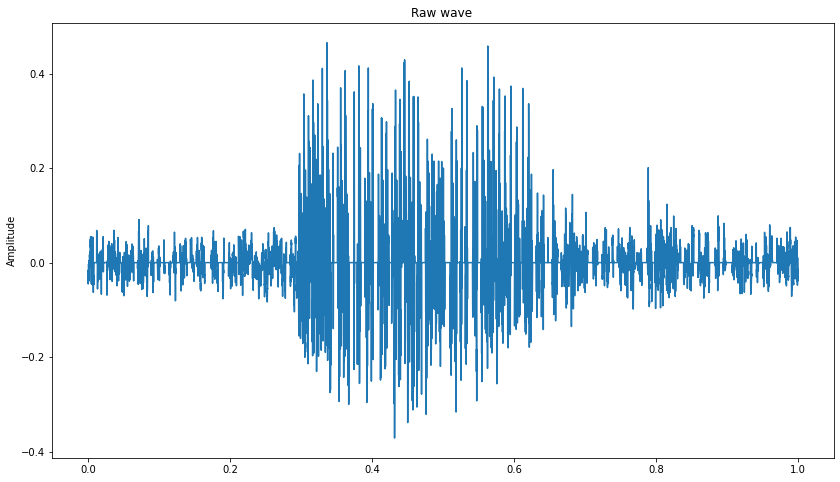

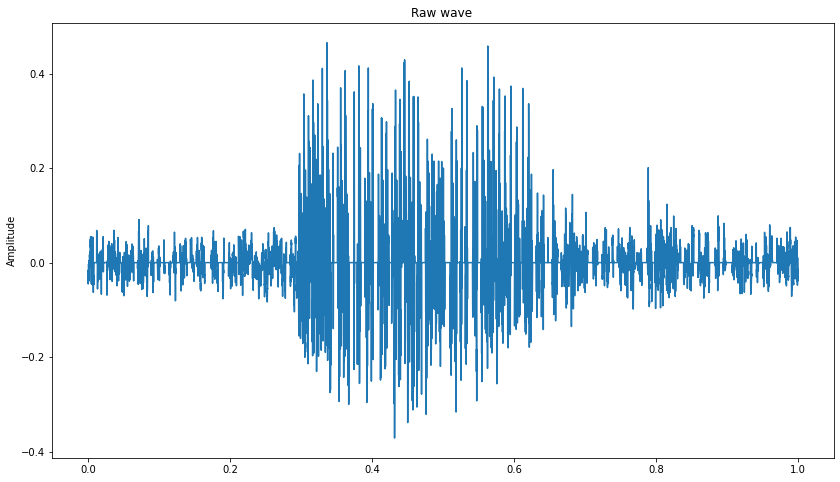

In [ ]:
#######################
# #Just for visualidation
# #######################
# def plot_time_series(data):
#     fig = plt.figure(figsize=(14, 8))
#     plt.title('Raw wave ')
#     plt.ylabel('Amplitude')
#     plt.plot(np.linspace(0, 1, len(data)), data)
#     plt.show()

# data = load_audio_file("/content/s1_train_release/bird/train_bird_8400.wav")
# plot_time_series(data)

# data_wn = white_noise(data)
# plot_time_series(data)
# ipd.Audio(data_wn, rate=16000)

# # data_shift = shift(data)
# # #plot_time_series(data_shift)
# # #ipd.Audio(data_shift, rate=16000)

# # data_pitch = pitch(data, -3) #-2/-2 AND 2/3 ARE GOOD VALUES
# # plot_time_series(data_pitch)
# # ipd.Audio(data_pitch, rate=16000)

# #this works
# # save_wav_file('/content/s1_train_release/bird/train_bird_8400_AUGMENTED.wav', data_wn)
# # print('saved!')

# #data_speed = speed(data, 1) #1.5 AND 0.5 ARE GOOD VALUES 
# # plot_time_series(data_speed)
# # ipd.Audio(data_speed, rate=16000)


# # with wave.open("/content/s1_train_release/bird/train_bird_8400.wav", "rb") as wave_file:
# #         sample_rate = wave_file.getframerate()

# # print(sample_rate)
# #ipd.Audio(data, rate=16000)

In [76]:
class CustomSpeechDataset(torch.utils.data.Dataset):
  def __init__(self, path, typ='train', transforms=None):

    assert typ == 'train' or typ == 'test', 'typ must be either "train" or "test"'

    self.typ = typ
    self.transforms = transforms
    self.targets = []

    if self.typ == 'train':
      self.class_names = sorted(os.listdir(path))
      num_classes = len(self.class_names)

      for class_idx, class_name in enumerate(self.class_names):
        class_dirx = os.path.join(path, class_name)
        wav_list = os.listdir(class_dirx)

        for wav_file in wav_list:
          self.targets.append({
              'filename': wav_file,
              'path': os.path.join(class_dirx, wav_file),
              'class': class_name
          })

    if self.typ == 'test':
      wav_list = os.listdir(path)
      for wav_file in wav_list:
        self.targets.append({
            'filename': wav_file,
            'path': os.path.join(path, wav_file)
        })
  
  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx.tolist()

    signal, sr = torchaudio.load(self.targets[idx]['path'], normalization=True)
    filename = self.targets[idx]['filename']

    if self.transforms:
      for transform in self.transforms:
        signal = transform(signal)

    if self.typ == 'train':
      clx_name = self.targets[idx]['class']
      return filename, signal, sr, clx_name
    
    elif self.typ == 'test':
      return filename, signal, sr

In [77]:
#%cd content


In [81]:
full_dataset = CustomSpeechDataset(path=train_folder, typ='train')
train_size = int(len(full_dataset)*0.9)
valid_size = len(full_dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

In [82]:
labels = full_dataset.class_names

In [83]:
labels_to_indices = {}
for idx, l in enumerate(labels):
  labels_to_indices[l] = idx

Let's next look at one example from the training set.

In [84]:
filename, waveform, sample_rate, label_id = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


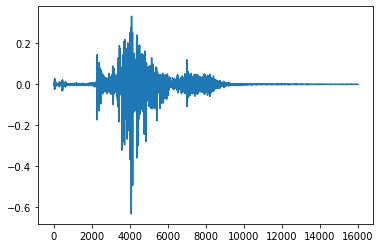

In [85]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# Let's plot the waveform using matplotlib
# We observe that the main audio activity happens at the later end of the clip
plt.plot(waveform.t().numpy());

In [86]:
# let's play the audio clip and hear it for ourselves!
ipd.Audio(waveform.numpy(), rate=sample_rate)

## Constant Sample Lengths
In order to insert our features into a model, we have to ensure that the features are of the same size. Below, we see that the sample length varies across the audio clips.

Let's pad the audio clips to a maximum sample length of 16000. (16000 sample length is equal to 1 second at 16,000 Hz sampling rate)
We will pad audio clips which are less than 1 second in length, with parts of itself.

In [87]:
audio_lens = []
for i in range(len(train_set)):
  audio_lens.append(train_set[i][1].size(1))

print('Max Sample Length:', max(audio_lens))
print('Min Sample Length:', min(audio_lens))

Max Sample Length: 16000
Min Sample Length: 16000


In [88]:
class PadAudio(torch.nn.Module):
  def __init__(self, req_length = 16000):
    super().__init__()
    self.req_length = req_length

  def forward(self, waveform):
    while waveform.size(1) < self.req_length:
      waveform = torch.cat((waveform, waveform[:, :self.req_length - waveform.size(1)]), axis=1)
    return waveform

# let's set up a list of transformations we are going to apply to the waveforms
transformations = []
transformations.append(PadAudio())

## Features
In this classification example, instead of using the raw waveform of the audio clips, we will craft handmade audio features known as melspectrograms instead.

For an in-depth explanation of what a melspectrogram is, I would highly recommend reading this article [here](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53).

In short, a melspectrogram is a way to represent an audio signal’s loudness as it varies over time at different frequencies, while scaled to how humans perceive sound. (We can easily tell the difference between 500 and 1000 Hz, but we can't between 10,000 and 10,500 Hz.)

![pic](https://i.ibb.co/WDsqsfb/melspectrogram.png)


TorchAudio has an in-built method that can help us with this transformation. We shall then apply log scaling.

In [89]:
from torchaudio.transforms import MelSpectrogram

# We define our own log transformation here
class LogMelTransform(torch.nn.Module):

    def __init__(self, log_offset = 1e-6):
        super().__init__()
        self.log_offset = log_offset

    def forward(self, melspectrogram):
        return torch.log(melspectrogram + self.log_offset)

# Let's append these new transformations
transformations.append(MelSpectrogram(sample_rate = 16000, n_mels = 128))
transformations.append(LogMelTransform())

## Data Augmentation

We will do a simple data augmentation process in order to increase the variations in our dataset.

In the audio domain, the augmentation technique known as [SpecAugment](https://arxiv.org/abs/1904.08779) is often used. It makes use of 3 steps:
- Time Warp (warps the spectrogram to the left or right)
- Frequency Masking (randomly masks a range of frequencies)
- Time Masking (randomly masks a range of time)

![specaugment pic](https://drive.google.com/uc?export=view&id=1C085-PlXVhjzh4kzCy869VHRGwC3aDHJ)

As Time Warp is computationally intensive and does not contribute significant improvement in results, we shall simply use Frequency and Time Masking in this example.

In [90]:
from torchaudio.transforms import TimeMasking, FrequencyMasking

eval_transformations = transformations.copy()

# Let's extend the list of transformations with the augmentations
transformations.append(TimeMasking(time_mask_param = 10)) # a maximum of 10 time steps will be masked
transformations.append(FrequencyMasking(freq_mask_param = 3)) # maximum of 3 freq channels will be masked

## Data Loaders

Let's now set up our data loaders so that we can streamline the batch loading of data for our model training later on. 

In [91]:
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN_MEMORY = True if device == 'cuda' else False

def train_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in transformations:
            waveform = transform(waveform)


        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)

    return (tensors, targets, filenames)

def eval_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)

        
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)
    filenames += [filename]

    return (tensors, targets, filenames)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    collate_fn=train_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=eval_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

## Setting up the Model

In this speech classification example, we will make use of a Long-Short-Term Memory Recurrent Neural Network (LSTM-RNN).

In [92]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index

In [93]:
# initialize the model class
model = RNN(input_size=128, hidden_size=512, num_layers=5, num_classes=len(labels), device=device, classes=labels).to(device)
model.eval()

RNN(
  (lstm): LSTM(128, 512, num_layers=5, batch_first=True)
  (fc): Linear(in_features=512, out_features=22, bias=True)
)

In [94]:
#%cd ../

In [40]:
#IF I WANT TO LOAD A CHECKPOINT
# model.load_state_dict(torch.load('speech_classification_lstm_s1s2speechcommandegg_layer5_hidden512_epch25_withAugmentation(NoAugForKaggleData)_accuracy95%.pt'))
# model.eval()

RNN(
  (lstm): LSTM(128, 512, num_layers=5, batch_first=True)
  (fc): Linear(in_features=512, out_features=22, bias=True)
)

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer.zero_grad()
num_epochs = 10

In [ ]:
for epoch in range(1,num_epochs+1):

  # training steps
  model.train()
  count_correct, count_total = 0, 0
  for idx, (features, targets, filenames) in enumerate(train_loader):

    features = features.to(device)
    targets = targets.to(device)

    # forward pass
    outputs = model(features)
    loss = criterion(outputs, targets)

    # backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # training results
    _, argmax = torch.max(outputs, 1)
    count_correct += (targets == argmax.squeeze()).sum().item()
    count_total += targets.size(0)

  train_acc = count_correct / count_total
  
  # evaluation steps
  model.eval()
  count_correct, count_total = 0, 0
  with torch.no_grad():
    for idx, (features, targets, filenames) in enumerate(valid_loader):

      features = features.to(device)
      targets = targets.to(device)

      # forward pass
      val_outputs = model(features)
      val_loss = criterion(val_outputs, targets)

      # validation results
      _, argmax = torch.max(val_outputs, 1)
      count_correct += (targets == argmax.squeeze()).sum().item()
      count_total += targets.size(0)

  # print results
  valid_acc = count_correct / count_total
  print('Epoch [{}/{}], Train loss = {:.4f}, Train accuracy = {:.2f}, Valid loss = {:.4f}, Valid accuracy = {:.2f}' 
        .format(epoch, num_epochs, loss.item(), 100*train_acc, val_loss.item(), 100*valid_acc))


Epoch [1/10], Train loss = 0.0511, Train accuracy = 97.21, Valid loss = 0.2193, Valid accuracy = 94.23
Epoch [2/10], Train loss = 0.1187, Train accuracy = 97.49, Valid loss = 0.4758, Valid accuracy = 94.06
Epoch [3/10], Train loss = 0.5797, Train accuracy = 97.67, Valid loss = 0.2605, Valid accuracy = 93.93
Epoch [4/10], Train loss = 0.0572, Train accuracy = 97.55, Valid loss = 0.1263, Valid accuracy = 94.13


In [120]:
torch.save(model.state_dict(), 'speech_classification_lstm_s1s2scnoisyegg_layer5_hidden512_epch50_withAugmentation(NoAugForKaggleData)_accuracy93%.pt')

## Test Set

In [98]:
#THE GIVEN HACKATHON s1 TEST DATASET
# !gdown https://drive.google.com/u/1/uc?id=167d2yVfQAhU30uVJySz1fQGIZUf81884&export=download
# !unzip -q -o s1_test_release.zip

#challenege 4 test dataset
!gdown https://drive.google.com/u/1/uc?id=14-ZAJNvwRoNllWaYCMf93xlkvph7BBBP&export=download
!unzip -q -o challenge_4_test_dataset.zip

Downloading...
From: https://drive.google.com/u/1/uc?id=14-ZAJNvwRoNllWaYCMf93xlkvph7BBBP
To: /content/challenge_4_test_dataset.zip
31.9MB [00:00, 148MB/s] 


In [121]:
test_folder = 'challenge_4_test_dataset'

In [122]:
## Initialise dataset object for test set
test_set = CustomSpeechDataset(path=test_folder, typ='test')

In [123]:
# define test collate function and set up test loader

def test_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate

    tensors, filenames = [], []

    # Gather in lists
    for filename, waveform, sample_rate in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        
        waveform = waveform.squeeze().T
        tensors += [waveform]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)

    return (tensors, filenames)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=test_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

In [124]:
# pass test set through the RNN model
model.eval()
pred_list, filename_list = [], []
with torch.no_grad():
  for idx, (features, filenames) in enumerate(test_loader):

    features = features.to(device)

    # forward pass
    outputs = model(features)

    # validation results
    _, argmax = torch.max(outputs, 1)
    pred_list += argmax.cpu().tolist()
    filename_list += filenames

## Submission of Results
Submission csv file should contain only 2 columns for filename and label, in that order. The file should be sorted by filename, and exclude headers. 

Refer to **sample_submission.csv** for an example.

In [125]:
result_tuple = list(zip(filename_list, pred_list))
submission = pd.DataFrame(result_tuple, columns=['filename', 'pred'])
submission = submission.sort_values('filename').reset_index(drop=True)
submission['label'] = submission['pred'].apply(lambda x: labels[x])

In [127]:
submission[['filename', 'label']].head()
submission[['filename', 'label']].to_csv('challenge_4_team_ACJC_s1s2scnoisyegg_layer5__hidden512_epoch40_withAugmentation(NoAugToKaggleData)_valAccu93.csv', header=None, index=None)